In [65]:
#https://github.com/Youngphone/spam_email
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [ ]:
#加载数据 0 ham正常邮件 1spam垃圾邮件
data = pd.read_csv('/content/NB_mail/spam_ham_dataset.csv')
data = data.iloc[:,2:]
data.head()

In [68]:
print('这份数据包含{}条邮件'.format(data.shape[0]))
print('正常邮件一共有{}条'.format(data['label_num'].value_counts()[0]))
print('垃圾邮件一共有{}条'.format(data['label_num'].value_counts()[1]))

这份数据包含5171条邮件
正常邮件一共有3672条
垃圾邮件一共有1499条


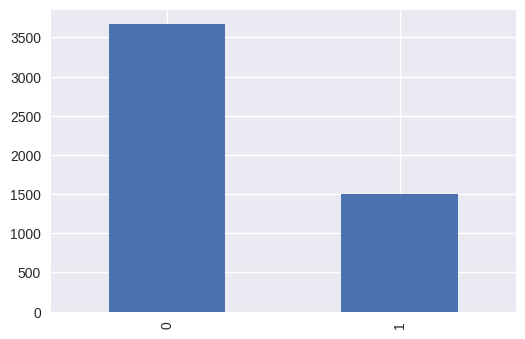

In [69]:
plt.style.use('seaborn')
plt.figure(figsize=(6,4), dpi=100)
data['label_num'].value_counts().plot(kind='bar')

In [70]:
#邮件中含有大小写，先将单词替换为小写
data['text'] = data['text'].str.lower()
data.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291\r\n...,0
1,"subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: re : indian springs\r\nthis deal is t...,0


In [71]:
#删除邮件中英语停用词
#https://zhuanlan.zhihu.com/p/34671514
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.add('subject')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
#词形还原函数
#https://www.cnblogs.com/jclian91/p/9898511.html
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z]+')
    token = tokenizer.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

In [81]:
nltk.download('wordnet')
#用wordnet实现词形还原
#https://zhuanlan.zhihu.com/p/26527203
data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TypeError: ignored

In [82]:
X = data['text']
y = data['label_num']
X_train, X_test, y_train,y_test = train_test_split(X,y,train_size = 0.7)#训测比7:3

In [83]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis = 1)

In [86]:
ham_train = train[train['label_num'] == 0] # 正常邮件
spam_train = train[train['label_num'] == 1] # 垃圾邮件

In [85]:
print('训练集含有{}封邮件，测试集含有{}封邮件'.format(train.shape[0], test.shape[0]))

训练集含有3619封邮件，测试集含有1552封邮件


0    2598
1    1021
Name: label_num, dtype: int64


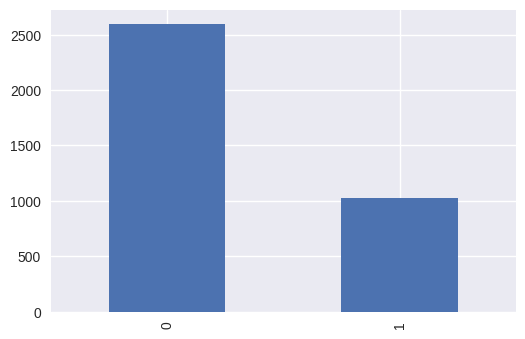

In [87]:
#训练集中垃圾邮件与正常邮件数量
print(train['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
train['label_num'].value_counts().plot(kind='bar')

0    1121
1     431
Name: label_num, dtype: int64


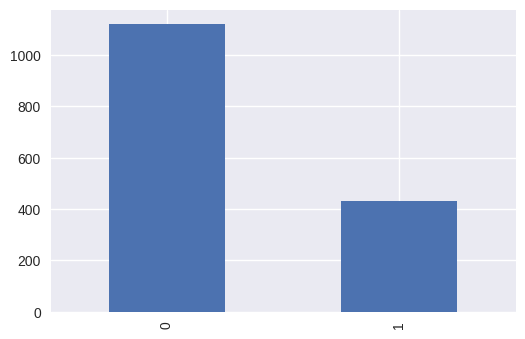

In [ ]:
#测试集中垃圾邮件与正常邮件数量
print(test['label_num'].value_counts())
plt.figure(figsize=(6, 4), dpi=100)
test['label_num'].value_counts().plot(kind='bar')

In [88]:
# 各取30封组成词库
ham_train_part = ham_train['text'].sample(30, random_state=42) 
spam_train_part = spam_train['text'].sample(30, random_state=42)
part_words = []
for text in pd.concat([ham_train_part,spam_train_part]):
    part_words += text

In [ ]:
part_words_set = set(part_words)#去除重复单词
print('单词表一共有{}个单词'.format(len(part_words_set)))

单词表一共有2672个单词


In [90]:
# 将正常邮件与垃圾邮件的单词都整理为句子，单词间以空格相隔，CountVectorizer()的句子里，单词是以空格分隔的
train_part_texts = [' '.join(text) for text in np.concatenate((spam_train_part.values, ham_train_part.values))]
# 训练集所有的单词整理成句子列表
train_all_texts = [' '.join(text) for text in train['text']]
# 测试集所有的单词整理成句子列表
test_all_texts = [' '.join(text) for text in test['text']]

In [97]:
cv = CountVectorizer()
#https://blog.csdn.net/weixin_38278334/article/details/82320307
part_fit = cv.fit(train_part_texts) # 以部分句子为参考
train_all_count = cv.transform(train_all_texts) # 对训练集所有邮件统计单词出现次数
test_all_count = cv.transform(test_all_texts) # 对测试集所有邮件统计单词出现次数
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)#标准化
test_tfidf_matrix = tfidf.fit_transform(test_all_count)
#print(train_all_count)
#print(train_tfidf_matrix)

In [100]:
#建立模型
#https://blog.csdn.net/TeFuirnever/article/details/100125386
model  = MultinomialNB()
model.fit(train_tfidf_matrix, y_train)
model.score(test_tfidf_matrix,y_test)

0.9413659793814433

In [ ]:
y_pred = model.predict_proba(test_tfidf_matrix)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
auc = auc(fpr, tpr)

Text(0, 0.5, 'tpr')

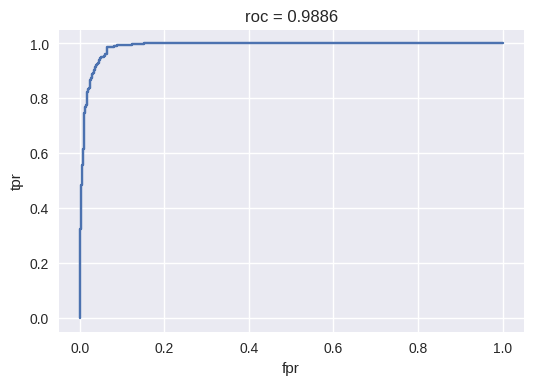

In [ ]:
# roc 曲线
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(fpr, tpr)
plt.title('roc = {:.4f}'.format(auc))
plt.xlabel('fpr')
plt.ylabel('tpr')

# 新段落